In [15]:
%load_ext autoreload
%autoreload 2



In [60]:
!pip3 install --upgrade pydot
!pip3 install --upgrade graphviz

In [67]:
# pip3 install pydotplus 
!pip3 install python-graphviz

ERROR: Could not find a version that satisfies the requirement python-graphviz (from versions: none)
ERROR: No matching distribution found for python-graphviz


In [24]:
import tensorflow.keras as keras

In [70]:
import random

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.dpi'] = 50


import nltk
from nltk.corpus import movie_reviews

from sklearn.model_selection import train_test_split


import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras import layers,Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding
from tensorflow.keras.layers import Bidirectional, Concatenate
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import GlobalAveragePooling1D



In [2]:
documents = [(' '.join(list(movie_reviews.words(fileid))), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

documents = [(text, 1) if label == "pos" else (text, 0)
             for (text, label) in documents]

random.shuffle(documents)


In [12]:
print('review sample text:' + documents[0][0][1:50])
print('review sentiment: ' + str(documents[0][1]))


review sample text:f you ' ve been following william fichtner ' s ca
review sentiment: 0


In [20]:
train, test = train_test_split(documents, test_size = 0.2 , random_state = 42)
print('The shape of train : ' + str(len(train)))
print('The shape of test : ' + str(len(test)))

The shape of train : 1600
The shape of test : 400


In [21]:
#To ways to represent the text
# 1. Text to integer sequence with padding
# 2. Text to one hot encoding - BoW approach


In [28]:
#splitting into independent and target variables
x_train = [ name for name,gender in train]
y_train = [gender for name,gender in train]

print(len(x_train))
print(len(y_train))

1600
1600


In [35]:
NUM_WORDS = 100_00
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(x_train)
print('Number of words including the padding character :' + str(tokenizer.num_words + 1))
print(list(tokenizer.word_index.items())[:10])

Number of words including the padding character :10001
[('the', 1), ('a', 2), ('and', 3), ('of', 4), ('to', 5), ("'", 6), ('is', 7), ('in', 8), ('s', 9), ('it', 10)]


In [36]:
#Approach 1 Sequence based embedding derivation

In [38]:
text_ints = tokenizer.texts_to_sequences(x_train)
print(len(x_train[1000].split(' ')))  ## original text word number
print(len(text_ints[1000]))  ## sequence token number


769
576


In [41]:
print('Sequence representation :' +str(text_ints[1000]))

Sequence representation :[141, 3662, 3, 604, 3798, 11, 6, 3593, 6, 7, 139, 1, 566, 22, 191, 21, 1, 286, 5, 7404, 67, 4312, 5513, 15, 8696, 28, 903, 7, 358, 1, 4499, 2686, 5320, 14, 3228, 42, 205, 917, 2, 77, 2733, 691, 11, 6, 9, 1814, 299, 48, 1155, 4, 39, 1, 493, 83, 3, 117, 1, 16, 37, 3080, 45, 29, 55, 1165, 4775, 112, 24, 38, 385, 10, 42, 10, 7, 7792, 1853, 5868, 50, 1, 245, 9438, 3977, 2300, 9313, 1, 1160, 550, 5, 25, 27, 8765, 24, 3743, 14, 1, 265, 454, 50, 2236, 3842, 9995, 6436, 13, 3814, 2, 2361, 1937, 7032, 3, 114, 22, 39, 272, 1433, 1086, 316, 2, 81, 195, 1074, 3, 2, 81, 206, 5737, 3999, 195, 35, 1, 3523, 607, 4, 1258, 3, 6394, 3, 52, 5329, 139, 4518, 12, 26, 4, 6, 9, 66, 1302, 14, 141, 1715, 4, 31, 29, 540, 6, 23, 800, 13, 1, 69, 124, 6, 9, 2, 962, 111, 391, 1258, 3, 65, 300, 6394, 22, 14, 52, 4719, 155, 33, 229, 84, 2, 962, 221, 1, 427, 154, 318, 49, 34, 161, 5, 748, 5, 38, 4045, 146, 343, 1591, 20, 154, 126, 368, 6394, 394, 5, 52, 382, 20, 1258, 6, 9, 90, 653, 2, 2103, 5, 

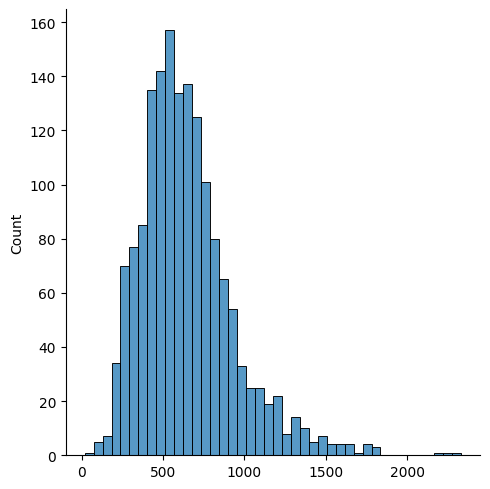

In [43]:
## Check the text len distribution
texts_lens = [len(n) for n in text_ints]
texts_lens
import seaborn as sns
sns.displot(texts_lens)

In [44]:
## Find the maxlen of the texts
max_len = texts_lens[np.argmax(texts_lens)]
max_len

2333

In [47]:
PADDING = 400 
texts_ints_pad = sequence.pad_sequences(text_ints, maxlen=PADDING, padding='pre',truncating='pre')
texts_ints_pad[:10]

array([[1256, 4308,   14, ...,   88,   67, 1292],
       [   0,    0,    0, ...,  925,   13, 2068],
       [  90,  862, 4810, ...,  170,    5,  188],
       ...,
       [   9,  245,    5, ...,   19,   34,  778],
       [ 701,    5,    1, ...,    1,    4,  507],
       [3056,  439,  124, ..., 2982,  181, 1305]], dtype=int32)

In [48]:
## Gereate X and y for training
X_train = np.array(texts_ints_pad).astype('int32')
y_train = np.array(y_train)

## Gereate X and y for testing in the same way
X_test_texts = [n for (n, l) in test]
X_test = np.array(
    sequence.pad_sequences(tokenizer.texts_to_sequences(X_test_texts),
                           maxlen=max_len,
                           padding='pre',
                           truncating='pre')).astype('int32')
y_test = np.array([l for (n, l) in test])

In [49]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1600, 400)
(1600,)
(400, 2333)
(400,)


In [50]:
# Modelling 

In [51]:
## A few DL hyperparameters
BATCH_SIZE = 128
EPOCHS = 25
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 128

In [53]:
# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

In [73]:
# one Embedding with 2 dense layers
vocab_size = tokenizer.num_words +  1
model_seq = Sequential()
model_seq.add(Embedding(
    input_dim = vocab_size,
    output_dim = EMBEDDING_DIM,
    input_length = PADDING,
    mask_zero = True            
))
model_seq.add(GlobalAveragePooling1D())
model_seq.add(Dense(16,activation='relu',name = 'Dense_Layer_1'))
model_seq.add(Dense(16,activation='relu',name = 'Dense_Layer_2'))
model_seq.add(Dense(1,activation='sigmoid',name = 'Output_Layer'))

model_seq.compile(
     loss = 'binary_crossentropy'
    ,optimizer = 'adam'
    ,metrics = ['accuracy']
)





In [74]:
#plot_model(model_seq, show_shapes=True)

In [75]:
history2 = model_seq.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
10/10 - 6s - loss: 0.6929 - accuracy: 0.5000 - val_loss: 0.6924 - val_accuracy: 0.4750 - 6s/epoch - 617ms/step
Epoch 2/25
10/10 - 2s - loss: 0.6903 - accuracy: 0.5125 - val_loss: 0.6904 - val_accuracy: 0.4750 - 2s/epoch - 165ms/step
Epoch 3/25
10/10 - 1s - loss: 0.6855 - accuracy: 0.5133 - val_loss: 0.6867 - val_accuracy: 0.4781 - 1s/epoch - 119ms/step
Epoch 4/25
10/10 - 1s - loss: 0.6779 - accuracy: 0.5406 - val_loss: 0.6815 - val_accuracy: 0.5031 - 963ms/epoch - 96ms/step
Epoch 5/25
10/10 - 1s - loss: 0.6657 - accuracy: 0.6250 - val_loss: 0.6733 - val_accuracy: 0.5437 - 840ms/epoch - 84ms/step
Epoch 6/25
10/10 - 1s - loss: 0.6491 - accuracy: 0.6516 - val_loss: 0.6607 - val_accuracy: 0.5938 - 1s/epoch - 102ms/step
Epoch 7/25
10/10 - 1s - loss: 0.6254 - accuracy: 0.7516 - val_loss: 0.6500 - val_accuracy: 0.5750 - 817ms/epoch - 82ms/step
Epoch 8/25
10/10 - 1s - loss: 0.5945 - accuracy: 0.7875 - val_loss: 0.6285 - val_accuracy: 0.6438 - 843ms/epoch - 84ms/step
Epoch 9/25
10/10

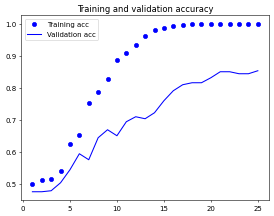

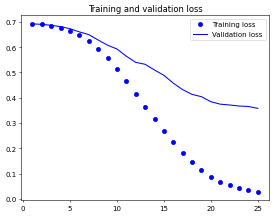

In [76]:
plot1(history2)

In [77]:
metrics_seq = model_seq.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)
print('The model accuracy on the validation set '+ str(metrics_seq[1]))
print('The Loss on the validation set '+ str(metrics_seq[0]))

4/4 - 2s - loss: 0.3216 - accuracy: 0.8625 - 2s/epoch - 561ms/step
The model accuracy on the validation set 0.862500011920929
The Loss on the validation set 0.3215598165988922


In [85]:
# Layers - Embedding - 1, LSTM - 2, Dense - 1
vocab_size = tokenizer.num_words +  1
model_lstm = Sequential()
model_lstm.add(Embedding(
    input_dim = vocab_size,
    output_dim = EMBEDDING_DIM,
    input_length = PADDING,
    mask_zero = True            
))

model_lstm.add(LSTM(16,return_sequences = True , dropout = 0.2,recurrent_dropout = 0.2, name = 'LSTM_1'))
model_lstm.add(LSTM(16,dropout = 0.2,recurrent_dropout = 0.2,  name = 'LSTM_2'))
model_lstm.add(Dense(1,activation='sigmoid',name = 'Output_Layer'))

model_lstm.compile(
     loss = 'binary_crossentropy'
    ,optimizer = 'adam'
    ,metrics = ['accuracy']
)



In [86]:
history_lstm = model_lstm.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=0.2)

Epoch 1/25
10/10 - 37s - loss: 0.6920 - accuracy: 0.5352 - val_loss: 0.6929 - val_accuracy: 0.4750 - 37s/epoch - 4s/step
Epoch 2/25
10/10 - 30s - loss: 0.6829 - accuracy: 0.5383 - val_loss: 0.6903 - val_accuracy: 0.4969 - 30s/epoch - 3s/step
Epoch 3/25
10/10 - 30s - loss: 0.6563 - accuracy: 0.6492 - val_loss: 0.6741 - val_accuracy: 0.5500 - 30s/epoch - 3s/step
Epoch 4/25
10/10 - 27s - loss: 0.5638 - accuracy: 0.7891 - val_loss: 0.6137 - val_accuracy: 0.6594 - 27s/epoch - 3s/step
Epoch 5/25
10/10 - 21s - loss: 0.3880 - accuracy: 0.8859 - val_loss: 0.5473 - val_accuracy: 0.7219 - 21s/epoch - 2s/step
Epoch 6/25
10/10 - 28s - loss: 0.2663 - accuracy: 0.9430 - val_loss: 0.5489 - val_accuracy: 0.7375 - 28s/epoch - 3s/step
Epoch 7/25
10/10 - 25s - loss: 0.1830 - accuracy: 0.9758 - val_loss: 0.6259 - val_accuracy: 0.7312 - 25s/epoch - 2s/step
Epoch 8/25
10/10 - 35s - loss: 0.1267 - accuracy: 0.9891 - val_loss: 0.6225 - val_accuracy: 0.7344 - 35s/epoch - 3s/step
Epoch 9/25
10/10 - 17s - loss: 0

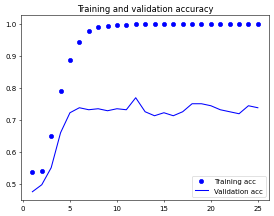

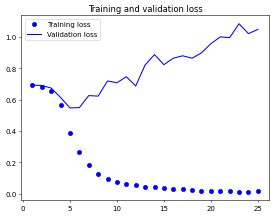

In [87]:
plot1(history_lstm)

In [88]:
metrics_lstm = model_lstm.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)
print('The model accuracy on the validation set '+ str(metrics_lstm[1]))
print('The Loss on the validation set '+ str(metrics_lstm[0]))

4/4 - 9s - loss: 1.1073 - accuracy: 0.7075 - 9s/epoch - 2s/step
The model accuracy on the validation set 0.7074999809265137
The Loss on the validation set 1.1073344945907593
